In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nba_py import shotchart
from nba_py import player
from matplotlib import colors
import seaborn as sns
%matplotlib inline

In [2]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Kirk Goldsberry for plotting the nba court
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -48), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [410]:
def create_bins(df, league_average = None, bin_number_x = 25, bin_number_y = 25, \
                width = 500, height = 350, norm_x = 250, norm_y = 48):
    x_bins, y_bins = [], []
    copied_df = df.copy()
    keys = []
    location_counts, location_made = {}, {}
    locations_shots = {} # real locations of shots which will be connected to bins and later arithmetic middle will
                         # be found
    bin_size_x = width / float(bin_number_x)
    print(bin_size_x)
    for i in range(len(df)):
        x_shot_orig, y_shot_orig = df.iloc[i].LOC_X, df.iloc[i].LOC_Y
        x_shot = x_shot_orig + norm_x # to put minimum to zero
        y_shot = y_shot_orig + norm_y # to put minimum to zero (.5 is lacking, but just so i can be working with integers)
        
        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)    
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)
        
        #x_bins.append(curr_bin_x_coord)
        #y_bins.append(curr_bin_y_coord)
        
        key = (curr_x_bin, curr_y_bin)
        keys.append(key)
        if key in location_counts:
            location_counts[key] = location_counts[key] + 1
        else:
            location_counts[key] = 1
        
        if key in location_made:
            location_made[key] = location_made[key] + df.iloc[i].SHOT_MADE_FLAG
        else:
            location_made[key] = df.iloc[i].SHOT_MADE_FLAG
            
        if key in locations_shots:
            locations_shots[key].append((x_shot_orig, y_shot_orig))
        else:
            locations_shots[key] = [(x_shot_orig, y_shot_orig)]
        
    shot_locations_percentage = [] # percentage in given bin
    shot_locations_counts = []
    key_x, key_y = [], []
    league_avg_comp = []
    for j in range(len(df)):
        key = keys[j]
        shot_percent = float(location_made[key]) / location_counts[key]
        #shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            shot_zone_basic, shot_zone_area = df.iloc[i].SHOT_ZONE_BASIC, df.iloc[i].SHOT_ZONE_AREA
            distance = df.iloc[i].SHOT_ZONE_RANGE
            avg_percentage = league_average.loc[(league_average.SHOT_ZONE_BASIC == shot_zone_basic) & \
                                                (league_average.SHOT_ZONE_AREA == shot_zone_area) & \
                                               (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT
            league_avg_comp.append(np.clip((shot_percent - avg_percentage) * 100, -30, 30))
        shot_locations_counts.append(location_counts[key])
        x_bins.append(np.mean([x_loc for x_loc, y_loc in locations_shots[key]]))
        y_bins.append(np.mean([y_loc for x_loc, y_loc in locations_shots[key]]))
        key_x.append(key[0])
        key_y.append(key[1])
        
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    if league_average is not None:
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = league_avg_comp
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['BIN_X'] = key_x
    copied_df['BIN_Y'] = key_y
    
    return copied_df
    

In [462]:
plt.style.use('seaborn')

In [463]:
# setting up data
season = "2006-07"
player_name = "LeBron"
player_surname = "James"
player_id = player.get_player(player_name, player_surname, season=season)
player_data = shotchart.ShotChart(player_id=player_id, season=season)
league_average = player_data.league_average()

In [464]:
player_df = player_data.shot_chart()
player_df.LOC_X = -player_df.LOC_X # REAL DATA IS FLIPPED
player_df = player_df.loc[player_df.LOC_Y < 300] # drop shots that aren't close to the th
len(player_df)

1605

In [465]:
binned_df = create_bins(player_df, league_average=league_average, bin_number_x=25, bin_number_y=25)


20.0


In [475]:
#cleared_df = binned_df
cleared_df = binned_df.loc[binned_df.LOC_COUNTS>1]

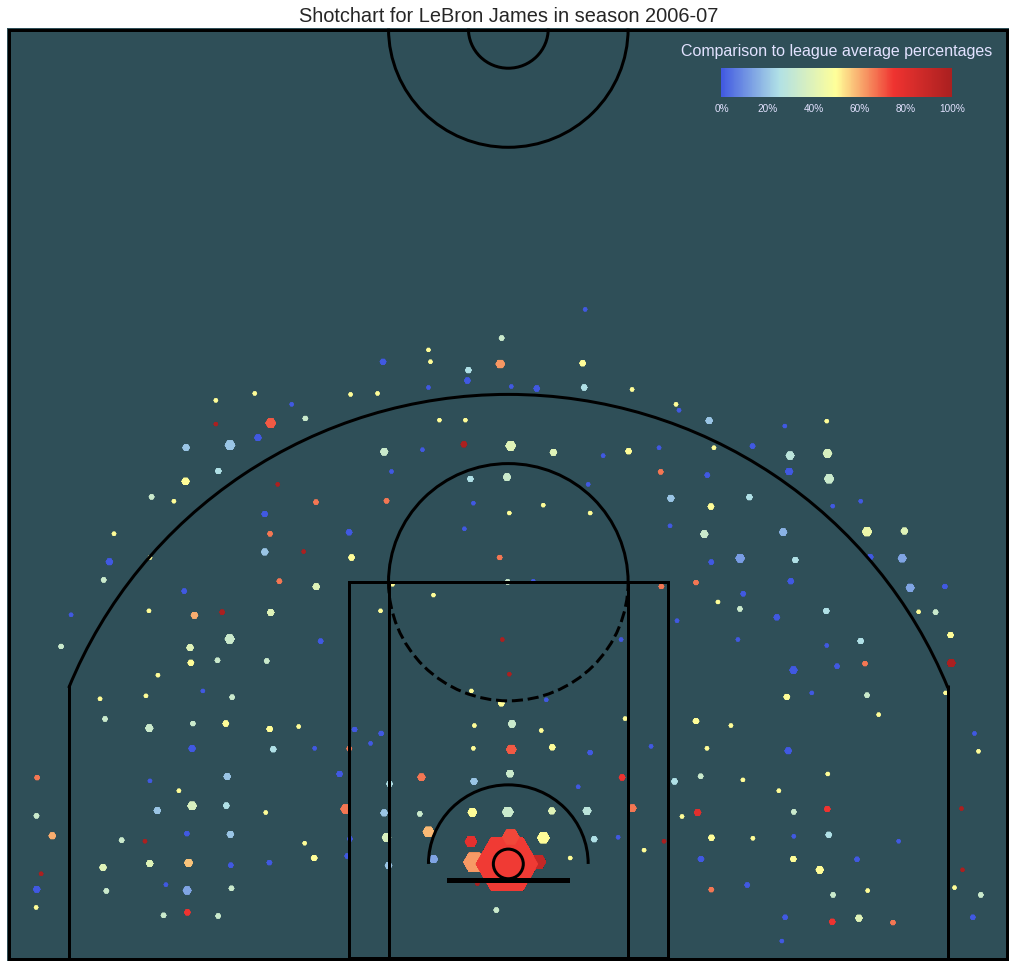

In [495]:
fig = plt.figure(figsize=(16, 16))
#colors_dict = {0:'red', 1:'green'}
cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)
plt.scatter(x=cleared_df.LOC_X, y=cleared_df.LOC_Y, marker='H', s=10*cleared_df.LOC_COUNTS, c=cleared_df.LOC_PERCENTAGE, cmap=cmap)

#plt.xticks(np.arange(-250, 251, 14.2))
#plt.yticks(np.arange(-48, 400, 14.2))
#plt.grid()

# Changing court color
plt.gca().set_facecolor('#2F4F58')
curr_ax = plt.gca()

# Removing ticks
plt.xticks([])
plt.yticks([])

# Title
plt.title("Shotchart for " + player_name + " " + player_surname + " in season " + season, size=20)

# Drawing court
draw_court(ax=curr_ax, outer_lines=True, lw=3)
plt.xlim(-251,251)
plt.ylim(-49,423)

# Colorbar
cax = fig.add_axes([0.7, 0.82, 0.2, 0.025])
colorbar = plt.colorbar(cax=cax, orientation='horizontal', format='%d%%')
#colorbar = plt.colorbar(cax=cax, orientation='horizontal', format='%+d%%') # + is for positive percentage
cax.set_xlabel("Comparison to league average percentages",
            fontsize=16, labelpad=-70, color="#E2E2FF")
colorbar.outline.set_visible(False)
plt.setp(plt.getp(colorbar.ax.axes, 'xticklabels'), color="#E2E2FF")

# Saving figure
plt.savefig('lebron.png', bbox_inches='tight')
#colorbar.set_label('Comparison to league average percentages', color='#E2E2FF', size=16, coords=(1.5, 1.5))
plt.show()

In [484]:
league_average

,GRID_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,FGA,FGM,FG_PCT
0,League Averages,Above the Break 3,Back Court(BC),Back Court Shot,125,2,0.016
1,League Averages,Above the Break 3,Center(C),24+ ft.,6301,2159,0.343
2,League Averages,Above the Break 3,Left Side Center(LC),24+ ft.,11690,4127,0.353
3,League Averages,Above the Break 3,Right Side Center(RC),24+ ft.,11408,4110,0.360
4,League Averages,Backcourt,Back Court(BC),Back Court Shot,376,10,0.027
5,League Averages,In The Paint (Non-RA),Center(C),8-16 ft.,5347,2287,0.428
6,League Averages,In The Paint (Non-RA),Center(C),Less Than 8 ft.,16224,6700,0.413
7,League Averages,In The Paint (Non-RA),Left Side(L),8-16 ft.,1830,742,0.405
8,League Averages,In The Paint (Non-RA),Right Side(R),8-16 ft.,1812,681,0.376
9,League Averages,Left Corner 3,Left Side(L),24+ ft.,6296,2420,0.384


In [103]:
binned_df.iloc[:30, [17,18, 24, 25, 26, 27, 28, 29]]
binned_df.loc[binned_df.BIN_LOC_X == 115.000000].iloc[:, [17,18, 24, 25, 26, 27, 28, 29]]

,LOC_X,LOC_Y,BIN_LOC_X,BIN_LOC_Y,LOC_PERCENTAGE,LOC_COUNTS,BIN_X,BIN_Y
1,129,43,115.0,40.6,0.7,5,3,1
7,130,17,115.0,40.6,0.7,5,3,1
12,110,45,115.0,40.6,0.7,5,3,1
62,76,44,115.0,40.6,0.7,5,3,1
111,130,54,115.0,40.6,0.7,5,3,1
